In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [4]:
df = pd.read_csv(r"./Aleppo2017_processed.csv",encoding='utf-8')
df

,id,time,gl
0,183,2015-05-16 05:35:41,162.0
1,183,2015-05-16 05:30:41,164.0
2,183,2015-05-16 05:25:41,168.0
3,183,2015-05-16 05:20:41,169.0
4,183,2015-05-16 05:15:41,170.0
...,...,...,...
14950656,293,2015-09-04 08:47:46,210.0
14950657,293,2015-09-04 08:42:46,211.0
14950658,293,2015-09-04 08:37:46,210.0
14950659,293,2015-09-04 08:32:46,207.0


In [5]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)

Index([263,  77, 193, 277, 229, 245, 155, 251, 111, 164,
       ...
       128, 264, 186, 162, 249,  39,  52, 266, 223, 289],
      dtype='int64', name='id', length=226)


In [12]:
#获取数据
# print("开始获取id为{}的被试的数据：---------------------------------".format(i))
data = df[df['id']== 236].copy() 

#将time列设成date数据类型
data['time'] = pd.to_datetime(data['time'])

#按照时间排序
data = data.sort_values(by='time') 

#提取月为单独的一列
data['month'] = data['time'].dt.month

#提取日为单独的一列
data['day'] = data['time'].dt.day

# #提取小时为单独的一列
data['hour'] = data['time'].dt.hour

# #提取分钟为单独的一列
data['minute'] = data['time'].dt.minute

# 提取周几（0表示星期一，1表示星期二，依此类推）
data['weekday'] = data['time'].dt.dayofweek

# 数据平滑
alpha = 0.5
data['smoothed'] = data['gl'].ewm(alpha=alpha, adjust=False).mean()

data = data.set_index('time')

data = data.astype(np.float32) # 修改数据类型

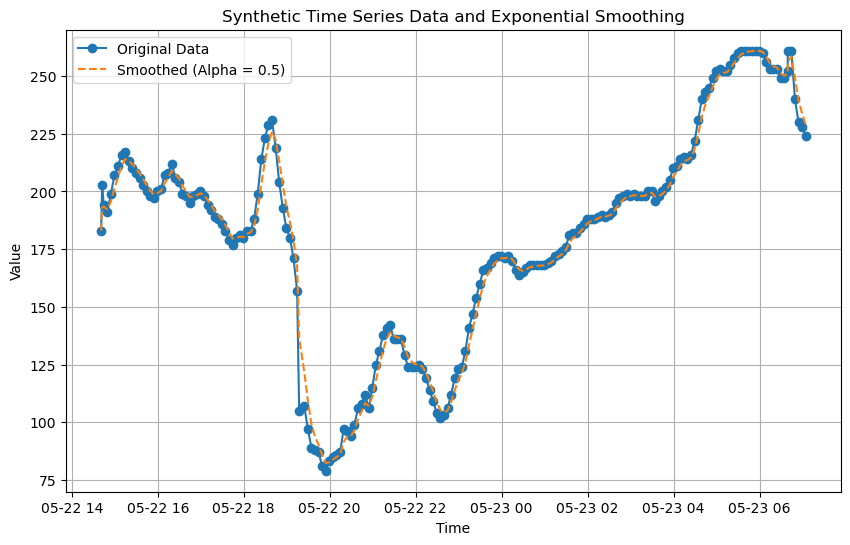

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot( data['gl'][:200], label='Original Data', marker='o')

plt.plot( data['smoothed'][:200], label=f'Smoothed (Alpha = {alpha})', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data and Exponential Smoothing')
plt.legend()
plt.grid(True)
plt.show()

In [150]:
# 数据缩放
sel_col = ['month','day','hour','minute','weekday','gl','smoothed']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))  

# 这里不能进行统一进行缩放，因为fit_transform返回值是numpy类型
for col in sel_col:                           
    data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
data.head()

,id,gl,month,day,hour,minute,weekday
time,,,,,,,
2015-05-22 14:40:56,236.0,-0.305361,-0.272727,0.4,0.217391,0.355932,0.333333
2015-05-22 14:42:23,236.0,-0.212121,-0.272727,0.4,0.217391,0.423729,0.333333
2015-05-22 14:44:31,236.0,-0.254079,-0.272727,0.4,0.217391,0.491525,0.333333
2015-05-22 14:49:31,236.0,-0.268065,-0.272727,0.4,0.217391,0.661017,0.333333
2015-05-22 14:54:31,236.0,-0.230769,-0.272727,0.4,0.217391,0.830508,0.333333


In [151]:
data['target'] = data['gl'].shift(-1)   
data.head()

,id,gl,month,day,hour,minute,weekday,target
time,,,,,,,,
2015-05-22 14:40:56,236.0,-0.305361,-0.272727,0.4,0.217391,0.355932,0.333333,-0.212121
2015-05-22 14:42:23,236.0,-0.212121,-0.272727,0.4,0.217391,0.423729,0.333333,-0.254079
2015-05-22 14:44:31,236.0,-0.254079,-0.272727,0.4,0.217391,0.491525,0.333333,-0.268065
2015-05-22 14:49:31,236.0,-0.268065,-0.272727,0.4,0.217391,0.661017,0.333333,-0.230769
2015-05-22 14:54:31,236.0,-0.230769,-0.272727,0.4,0.217391,0.830508,0.333333,-0.193473


In [152]:
data.tail()

,id,gl,month,day,hour,minute,weekday,target
time,,,,,,,,
2016-01-28 11:53:39,236.0,-0.034965,-1.0,0.8,-0.043478,0.796610,0.0,-0.072261
2016-01-28 11:58:39,236.0,-0.072261,-1.0,0.8,-0.043478,0.966102,0.0,-0.081585
2016-01-28 12:03:39,236.0,-0.081585,-1.0,0.8,0.043478,-0.898305,0.0,-0.090909
2016-01-28 12:08:39,236.0,-0.090909,-1.0,0.8,0.043478,-0.728814,0.0,-0.123543
2016-01-28 12:13:39,236.0,-0.123543,-1.0,0.8,0.043478,-0.559322,0.0,NaN


In [153]:
 # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
data = data.dropna() 
print(data.tail())

                        id        gl  month  day      hour    minute  weekday  \
time                                                                            
2016-01-28 11:48:39  236.0 -0.006993   -1.0  0.8 -0.043478  0.627119      0.0   
2016-01-28 11:53:39  236.0 -0.034965   -1.0  0.8 -0.043478  0.796610      0.0   
2016-01-28 11:58:39  236.0 -0.072261   -1.0  0.8 -0.043478  0.966102      0.0   
2016-01-28 12:03:39  236.0 -0.081585   -1.0  0.8  0.043478 -0.898305      0.0   
2016-01-28 12:08:39  236.0 -0.090909   -1.0  0.8  0.043478 -0.728814      0.0   

                       target  
time                           
2016-01-28 11:48:39 -0.034965  
2016-01-28 11:53:39 -0.072261  
2016-01-28 11:58:39 -0.081585  
2016-01-28 12:03:39 -0.090909  
2016-01-28 12:08:39 -0.123543  


In [154]:
import torch.nn as nn

input_dim = 6      # 数据的特征数
hidden_dim = 64    # 隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 1     # 预测值的特征数

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
#         print(out.shape)
        out = self.fc(out[:,-1,:]) 
#         print(out.shape)
        return out


In [155]:
# 创建两个列表，用来存储数据的特征和标签
data_feat, data_target = [],[]

# 设每条数据序列有24组数据
seq = 24

for index in range(len(data) - seq):
    # 构建特征集
    data_feat.append(data[['gl','month','day','hour','minute','weekday']][index: index + seq].values)
    # 构建target集
    data_target.append(data['target'][index + seq-1])

# 将特征集和标签集整理成numpy数组
data_feat = np.array(data_feat)
data_target = np.array(data_target)

In [156]:
data_feat.shape

(68559, 24, 6)

In [157]:
# 这里按照8:2的比例划分训练集和测试集
test_set_size = int(np.round(0.2*data.shape[0]))  # np.round(1)是四舍五入，
train_size = data_feat.shape[0] - (test_set_size) 
print(test_set_size)  # 输出测试集大小
print(train_size)     # 输出训练集大小

13717
54842


In [158]:
trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,6)).type(torch.Tensor)   
# 这里第一个维度自动确定，我们认为其为batch_size，因为在LSTM类的定义中，设置了batch_first=True
testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,6)).type(torch.Tensor)
trainY = torch.from_numpy(data_target[:train_size]).type(torch.Tensor)
testY  = torch.from_numpy(data_target[train_size:]).type(torch.Tensor)

In [159]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([54842, 24, 6])
y_train.shape =  torch.Size([54842])
x_test.shape =  torch.Size([13717, 24, 6])
y_test.shape =  torch.Size([13717])


In [115]:
batch_size=128
train = TensorDataset(trainX,trainY)
test = TensorDataset(testX,testY)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [160]:
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # 使用Adam优化算法
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数

# 设定数据遍历次数
num_epochs = 100

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [161]:
# train model
model.train()
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(trainX)
    
    loss = loss_fn(y_train_pred.squeeze(-1), trainY)
        
    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser.zero_grad()

    # Backward pass
    loss.backward()
    
    # Update parameters
    optimiser.step()
    
    if t % 10 == 0 and t != 0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "MSE: ", loss.item())

Epoch  10 MSE:  0.06179671734571457
Epoch  20 MSE:  0.014614597894251347
Epoch  30 MSE:  0.006851675920188427
Epoch  40 MSE:  0.003344119992107153
Epoch  50 MSE:  0.002541888505220413
Epoch  60 MSE:  0.0019402303732931614
Epoch  70 MSE:  0.001842570141889155
Epoch  80 MSE:  0.0017168769845739007
Epoch  90 MSE:  0.0016359684523195028


In [162]:
model.eval()
y_train_pred = model(trainX)
loss_fn(y_train_pred.squeeze(-1), trainY).item()

0.001569912419654429

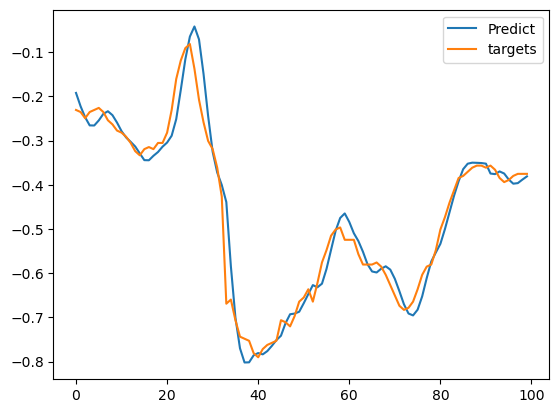

In [163]:
# "训练集效果图"
pred_value = y_train_pred.detach().numpy()
true_value = trainY.detach().numpy()   

plt.plot(pred_value[:100], label="Predict")    # 预测值
plt.plot(true_value[:100], label="targets")    # 真实值
plt.legend()
plt.show()

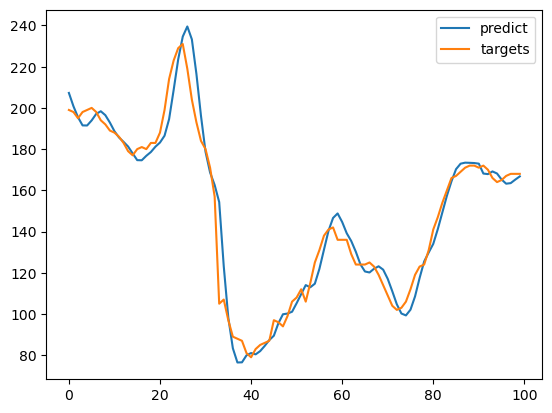

In [164]:
pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.plot(pred_value[:100], label="predict")    # 预测值
plt.plot(true_value[:100], label="targets")    # 真实值
plt.legend()
plt.show()

tensor(0.0073, grad_fn=<SqrtBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)


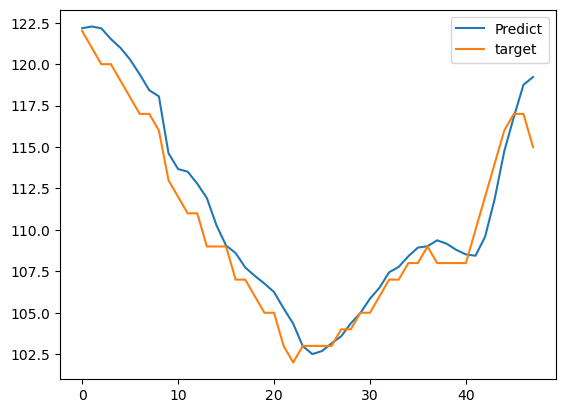

In [168]:
# "测试集效果图"
# make predictions
y_test_pred = model(testX[:48,:,:])
mse_loss = loss_fn(y_test_pred.squeeze(-1), testY[:48])
rmse_loss = torch.sqrt(mse_loss)
print(rmse_loss)

import torch.nn.functional as F

# 使用MAE损失函数计算损失
mae_loss = F.l1_loss(y_test_pred.squeeze(-1), testY[:48])
print(mae_loss)

pred_value = y_test_pred.detach().numpy().flatten()
true_value = testY.numpy()[:48]

pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.plot(pred_value, label="Predict")    # 预测值
plt.plot(true_value, label="target")    # 真实值
plt.legend()
plt.show()

###### correlation_matrix = np.corrcoef(pred_value.flatten(), true_value.flatten())[0,1]
correlation_matrix

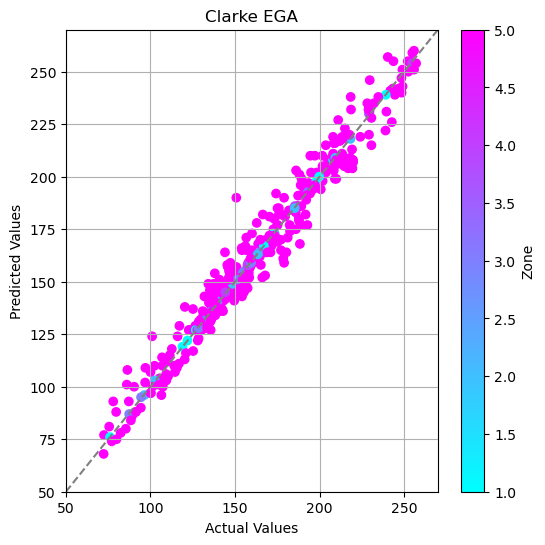

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据，实际观测值和预测值
actual_values = pred_value[:400].flatten() 
predicted_values =  true_value[0:400].flatten()

# 计算Clarke EGA图中的区域
def clarke_ega_region(actual, predicted):
    abs_diff = np.abs(predicted - actual)
    zones = np.zeros_like(abs_diff, dtype=int)
    zones[(abs_diff <= 0.2)] = 1
    zones[(abs_diff <= 0.4) & (abs_diff > 0.2)] = 2
    zones[(abs_diff <= 0.6) & (abs_diff > 0.4)] = 3
    zones[(abs_diff <= 0.8) & (abs_diff > 0.6)] = 4
    zones[(abs_diff > 0.8)] = 5
    return zones

zones = clarke_ega_region(actual_values, predicted_values)

# 绘制Clarke EGA图
plt.figure(figsize=(6, 6))
plt.scatter(actual_values, predicted_values, c=zones, cmap='cool', marker='o')
plt.plot([50, 270], [50, 270], color='gray', linestyle='--')
plt.xlim(50, 270)
plt.ylim(50, 270)
plt.title("Clarke EGA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
# 在图上添加区域标识
# plt.text(0.05, 0.92, 'A', fontsize=14, color='black')
# plt.text(0.25, 0.75, 'B', fontsize=14, color='black')
# plt.text(0.55, 0.65, 'C', fontsize=14, color='black')
# plt.text(0.75, 0.4, 'D', fontsize=14, color='black')
# plt.text(0.85, 0.15, 'E', fontsize=14, color='black')

plt.grid()
plt.colorbar(label="Zone")
plt.show()